<a href="https://colab.research.google.com/github/antoineodier/pytorchSeminar/blob/master/02_pytorch_de.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lineare Regression (fast ein Perceptron)
*****************************************


### Datensatz-Generierung

w, b, sigma: 57.21053211482911 20.0 12.0


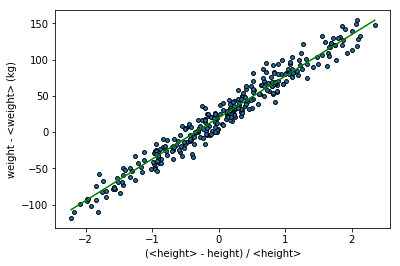

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Wir generieren einen Datensatz mit einer gewissen Streuung und einem Bias
random_state = 331  # reproduzierbare Ergebnisse
b = 20.  # Offset oder Bias
sigma = 12. # Noise
# w ist die Steigung der Linie
x, y, w = datasets.make_regression(n_samples=300, shuffle=True, n_features=1, 
                                   n_informative=1, noise=sigma, coef=True, bias=b,
                                   random_state=random_state)

# Generator Model w/o Noise
line_x = np.linspace(x.min(), x.max(), 100)[:, np.newaxis]
line_y = w * line_x + b

plt.xlabel('(<height> - height) / <height>')
plt.ylabel('weight - <weight> (kg)')
plt.scatter(x, y, marker='o', s=15, edgecolor='k')
#p = plt.scatter(line_x, line_y, c='g')
p = plt.plot(line_x, line_y, c='g')

print('w, b, sigma:', w, b, sigma)

Der vom Generator benutze Linearfunktion lautet also (einschließlich Noise):
$$y _i= w \cdot x_i + b + \sigma$$
wobei *w* = *coef*, *b* = *bias*, $\sigma$ = *sigma*


- Generator Modell mit (Grün) und ohne Noise (Blau)


## Linear Regression mit einem Perceptron

### Vorverarbeitung

In [0]:
# Konvertierung des Input nach torch Tensoren
x_in = torch.from_numpy(x).float()
print(x_in.size())  # (batch size, input dimension)

# Konvertierung des Targets nach torch Tensoren
y_true = torch.from_numpy(y).float()

print(y_true.size())  # (Batchgröße)

torch.Size([300, 1])
torch.Size([300])


In [0]:
import torch
import torch.nn as nn

        
# Simple lineare Regression
class RegrModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(RegrModel, self).__init__() 
        # Hier generierst du Instanzen aller Submodule des Netzwerks 
        
        # Simple Feed Forward Layer 
        # ist auch abgeleitet von der Klasse nn.Module
        # Erwartet Eingabedimension (batch size, input_dim)
        # Returns Tensor mit Dimension (batch size, output_dim)
        self.out = nn.Linear(input_dim, output_dim) 
        
    def forward(self, x):
        # Hier definierst du die Vorwärts-Sequenz
        # autograd generiert dynamisch einen Graphen bei jedem Durchlauf (darauf gehen wir unten noch näher ein)
        
        out = self.out(x)
        return out

- Eigene Network-Klasse abgeleitet von **nn.Module** (unterstützen nur Batch-Eingaben)
- Methoden __\_\_init\_\_()__ und  __forward()__ müssen definiert werden

### Instanz der Netzwerkklasse:

In [0]:
# Für dieses einfache Problem reichen diese Dimensionen (Perceptron - wie auf dem Bild oben):
input_dim = 1
output_dim = 1

model = RegrModel(input_dim, output_dim)

print(model)

RegrModel(
  (out): Linear(in_features=1, out_features=1, bias=True)
)


### Loss function
$$ MSE = \frac{1}{n} \sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} = \frac{1}{n} \sum_{i=1}^{n}{( (w \cdot x_i+ b)  - \hat{y}_i)^2}$$


In [0]:
# Differenzierbare Loss-Funktion: Vordefinierte Mean Squared Error als Loss
loss_function = nn.MSELoss()  

In [0]:
import torch.optim as optim

# Definiere einen Optimizer und verknüpfe mit Parametern des Netzwerks
optimizer = optim.SGD(model.parameters(), lr=0.001)  

### Training

In [0]:
num_epochs = 100
# Training durchführen
for epoch in range(num_epochs): 
    losses = []  # Speichert Losses aller Batches
    for i, x_i in enumerate(x_in):
        model.zero_grad()  # Setzt alle Gradienten auf None

        x_out = model(x_i)  # forward pass
        
        loss = loss_function(x_out.view(-1), y_true[i].view(-1))  # calculate loss

        # autograd ermittelt den backward Pass
        loss.backward()

        # Update der Gewichte mit SGD
        optimizer.step()

        losses.append(loss.item())

    if epoch % 10 == 0:
      print(epoch, np.mean(losses))

0 2347.083379713657
10 138.32890173193087
20 138.2990645802021
30 138.29898894753308
40 138.29898894753308
50 138.29898894753308
60 138.29898894753308
70 138.29898894753308
80 138.29898894753308
90 138.29898894753308


### Trained weights

out.weight tensor([[58.0705]])
out.bias tensor([19.9752])


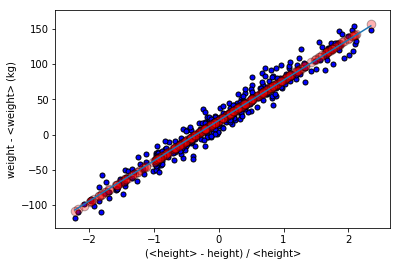

In [0]:
x_out = model(x_in)
y_pred = x_out.detach()  # vom Graphen lösen, macht eine Kopie

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

plt.scatter(x, y, marker='o', s=25, edgecolor='k', c='b')
plt.xlabel('(<height> - height) / <height>')
plt.ylabel('weight - <weight> (kg)')
plt.plot(line_x, line_y)
plt.scatter(x, y_pred, marker='o', s=75, edgecolor='k', c='r', alpha=0.3)

# Nicht-Lineares Multi-Layer-Perceptron
*****************************************

### Generierung eines nicht-linearen Datensatzes

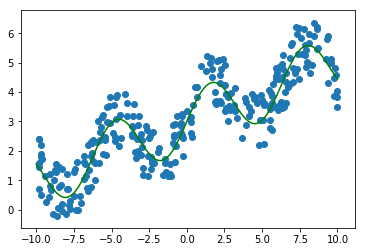

In [0]:
X = np.linspace(-10., 10., 100)

def sin_lin(X):
    w1, w2, w3, b = 1., 1., 0.2, 3.
    return w1*np.sin(X*w2) + w3*X + b

sin_y = sin_lin(X)

sample_size = 300
noise = 2.
data_x = np.random.random(sample_size) * 20. - 10
data_y = sin_lin(data_x) + np.random.random(len(data_x)) * noise - noise/2. 

plt.plot(X, sin_y, c='g')
plt.scatter(data_x, data_y)

### Vorbereitung

In [0]:
x_in = torch.from_numpy(data_x).float()
x_in = x_in.view(-1, 1)
print(x_in.size())  # (Batchgröße, Eingabedimension)

y_true = torch.from_numpy(data_y).float()

print(y_true.size())  # (Batchgröße)

model = RegrModel(1, 1)

optimizer = optim.SGD(model.parameters(), lr=0.0005)  

loss_function = nn.MSELoss()

torch.Size([300, 1])
torch.Size([300])


### Training

In [0]:
num_epochs = 100

# Training durchführen
for epoch in range(num_epochs): 
    losses = []  # Speichert Losses aller Batches
    for i, x_i in enumerate(x_in):
        model.zero_grad()  # Setzt alle Gradienten auf None

        x_out = model(x_i)  # forward pass
        
        loss = loss_function(x_out.view(-1), y_true[i].view(-1))  # calculate loss

        # autograd ermittelt den backward Pass.
        # Alle Gradienten für die Loss bzgl aller Tensoren mit requires_grad=True.
        loss.backward()

        # Update der Gewichte mit SGD. 
        optimizer.step()

        losses.append(loss.item())

    if epoch % 10 == 0:
      print(epoch, np.mean(losses))

0 7.546817859925019
10 0.7689186751985032
20 0.7570646625423554
30 0.7570626130634636
40 0.7570639104129752
50 0.7570640062221142
60 0.7570640062221142
70 0.7570640062221142
80 0.7570640062221142
90 0.7570640062221142


### Trainierte Gewichte des linearen Modells

out.weight tensor([[0.2114]])
out.bias tensor([2.9765])


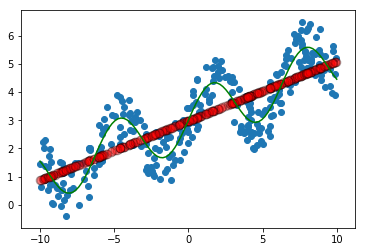

In [0]:
x_out = model(x_in)
y_pred = x_out.detach()

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

plt.plot(X, sin_y, c='g')
plt.scatter(data_x, data_y)
plt.scatter(data_x, y_pred, marker='o', s=75, edgecolor='k', c='r', alpha=0.3)

Unser lineares Perceptron kann nur lineare Strukturen lernen.

Nichtlinearität durch zusätzlichen Layer und nichtlineare Aktivierungsfunktion:

## Non-linear model

In [0]:
# NN mit einem hidden Layer
class NonLinModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NonLinModel, self).__init__() 
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.hidden(x)
        # out = torch.sigmoid(out)
        out = torch.tanh(out)
        out = self.out(out)
        return out

### Preprocessing

In [0]:
x_in = torch.from_numpy(data_x).float()
x_in = x_in.view(-1, 1)
print(x_in.size())  # (Batchgröße, Eingabedimension)

y_true = torch.from_numpy(data_y).float()

print(y_true.size())  # (Batchgröße)

model = NonLinModel(1, 5, 1) # (1, 10, 1)

optimizer = optim.SGD(model.parameters(), lr=0.001)  # 0.002

loss_function = nn.MSELoss()

torch.Size([300, 1])
torch.Size([300])


### Training

In [0]:
num_epochs = 100

# Training durchführen
for epoch in range(num_epochs): 
    losses = []  # Speichert Losses aller Batches
    for i, x_i in enumerate(x_in):
        model.zero_grad()  # Setzt alle Gradienten auf None

        x_out = model(x_i)  # do forward pass
        
        loss = loss_function(x_out.view(-1), y_true[i].view(-1))  # calculate loss

        # autograd ermittelt den backward Pass.
        # Alle Gradienten für die Loss bzgl aller Tensoren mit requires_grad=True.
        loss.backward()

        # Update der Gewichte mit SGD. 
        optimizer.step()

        losses.append(loss.item())

    if epoch % 10 == 0:
      print(epoch, np.mean(losses))

0 2.922828303418598
10 0.9462555494173527
20 0.9405705117649268
30 0.9367213211030018
40 0.9336189654313012
50 0.9309835448609617
60 0.9286552288794337
70 0.9264492637745965
80 0.9241319248187665
90 0.9213790857265849


### Trainierte Gewichte

hidden.weight tensor([[-1.1339],
        [ 0.1014],
        [ 0.0699],
        [-1.0059],
        [ 0.7509]])
hidden.bias tensor([ 0.1845,  0.5708,  0.9877,  0.4179, -1.0529])
out.weight tensor([[-0.3619,  1.1599,  1.2672, -0.4314, -0.1904]])
out.bias tensor([1.5648])


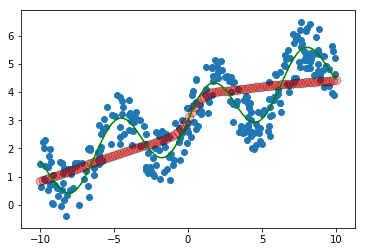

In [0]:
line_x = np.linspace(-10, 10, 100)
x_in2 = torch.tensor(line_x).float().view(-1, 1)

x_out = model(x_in2)
y_pred = x_out.detach()


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

plt.plot(X, sin_y, c='g')
plt.scatter(data_x, data_y)
plt.scatter(line_x, y_pred, marker='o', s=75, edgecolor='k', c='r', alpha=0.3)

# Neuronales Netzwerk für Klassifizierung
*****************************************
- Neuronales Netzwerk (aka "Multi-Layer-Perceptron" aka "Feed Forward Neural Network" mit "Fully Connected Layers")
- Am Beispiel eines Klassifizierungsproblems


- Die Anzahl der Klassen definiert die Anzahl der Knoten im Output Layer
- Jeder Knoten repräsentiert eine Klasse
- Der Output-Knoten mit der höchsten Aktivität wird als Prediction interpretiert

[tensorflow playground](https://playground.tensorflow.org:)

### Random Dataset Generierung mit Scikit-Learn

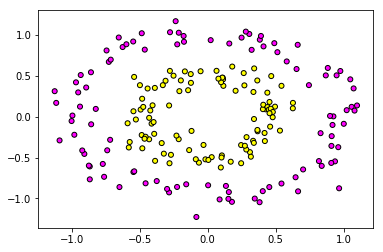

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=200, shuffle=True, noise=0.1, random_state=331, factor=0.5)
plt.scatter(x[:, 0], x[:, 1], marker='o', c=y, s=25, edgecolor='k', cmap='spring')

In [0]:
import torch
import torch.nn as nn

### Feed Forward Neural Network mit einem fully connected (dense) hidden Layer

In [0]:
# good practice: apply softmax afterwards -> often helps with training
class Net(nn.Module):
        
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__() 
        
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Hier definierst du die Vorwärts-Sequenz
        # autograd generiert dynamisch einen Graphen bei jedem Durchlauf
        # Debugging, bedingte Abzweigungen hier möglich!
        
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

### Vorverarbeitung

In [0]:
# Konvertierung der numpy Vektoren in PyTorch Float-Tensoren
x_in = torch.from_numpy(x).float()
print(x_in.size())  # (Batchgröße, Eingabedimension)
print(x_in.type())  # Default Datentyp ist FloatTensor

torch.Size([200, 2])
torch.FloatTensor


### GPU (CUDA)

In [0]:
x_in = x_in.cuda()  # Verschiebe auf GPU
print(x_in.type())  

torch.cuda.FloatTensor


### Target Tensor

In [0]:
# Konvertierung der numpy Target-Vektoren in PyTorch Long-Tensoren
# Target-Tensor für Klassifizierung muss Long Tensor sein

y_true = torch.from_numpy(y).long()
y_true = y_true.cuda()  # send to gpu 

print(y_true.size())  # (Batchgröße)
print(y_true.type())

torch.Size([200])
torch.cuda.LongTensor


### Network Instance

In [0]:
# Mit device können wir viele Paramater auf einmal elegant verschieben
device = torch.device('cuda')  # or 'cpu'

# oder:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = x_in.size(-1)  # mit -1 erhält man immer die letzte Dimension
hidden_dim = 6
output_dim = 2

model = Net(input_dim, hidden_dim, output_dim)
model.to(device)  # Verschiebe alle Parameter des Netzwerks auf device

print(model)

Net(
  (fc1): Linear(in_features=2, out_features=6, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=6, out_features=2, bias=True)
)


### Optimizer

In [0]:
import torch.optim as optim

# Definiere einen Optimizer und verknüpfe mit Parametern des Netzwerks
optimizer = optim.SGD(model.parameters(), lr=0.1)  

### Cross-Entropy Loss-Funktion

In [0]:
# Definiere Loss-Funktion für Multi-Class-Problem: CrossEntropy Loss
loss_function = nn.CrossEntropyLoss() 

# Wir haben softmax noch nicht angewendet!
# cross entropy loss = softmax + negative Log Loss

In [0]:
S = np.array([0.2, 0.7, 0.1])  # from softmax
L = np.array([1., 0., 0.])  # one-hot encoded truth info

# Maximierung von accuracy: 1 oder 0
acc = float(S.argmax() == L.argmax())
print(acc)

# allmost cross entropy: etwas differenzierter
prod = (L.T * S).sum()
print(prod)

# Minimierung von negative log loss - cross entropy: log() kommt aus der Information Theory
cent = - (L.T * np.log(S)).sum()
print(cent)

0.0
0.2
1.6094379124341003


## Autograd Graph

- Durch Definition des Forward Passes generiert Autograd dynamisch einen Graphen (DAG)
- Knoten des DAGs sind Tensoren
- Kanten des DAGs sind Operationen Tensor -> Tensor
- Backpropagation durch den Graph


### Backpropagation
[backpropagation demo](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/)


- Backpropagation bzgl. eines bestimmten Knoten kann ein- oder ausgeschaltet werden
- Tensoren speichern ihre Historie durch **requires_grad=True**
- Dadurch kann man ihren Gradienten berechnen, der in **x.grad** gespeichert ist nachdem man mit **x.backward()** backpropagation durchgeführt hat

In [0]:
# Alle Parameters des Netzwerks
for name, param in model.named_parameters():
    print(name, param.requires_grad, param.grad)

fc1.weight True None
fc1.bias True None
fc2.weight True None
fc2.bias True None


In [0]:
# x_out sollte auch requires_grad == True
# Let's check
for i, x_i in enumerate(x_in):
    x_out = model(x_i.cuda())
    print(i, x_out.requires_grad)
    break

RuntimeError: ignored

In [0]:
model.zero_grad()  # setzt all Gradienten auf None
for name, param in model.named_parameters():
    print(name, param.grad)

In [0]:
x_sum = x_out.sum()  # forward Operation
x_sum.backward()     # backprop
for name, param in model.named_parameters():
    print(name, param.grad)

## Training

In [0]:
# Let's train a few epochs:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_in = x_in.to(device)
y_true = y_true.to(device)
model.to(device)

model.eval()
model.train()
num_epochs = 100
for epoch in range(num_epochs): 
    losses = []  # Speichert Losses aller Batches
    for i, x_i in enumerate(x_in):
        model.zero_grad()  # Setzt alle Gradienten auf None

        x_out = model(x_i)  # do forward pass
        loss = loss_function(x_out.view(-1, 2), y_true[i].view(-1))  # calculate loss

        # autograd ermittelt den backward Pass.
        # Alle Gradienten für die Loss bzgl aller Tensoren mit requires_grad=True.
        loss.backward()

        # Update der Gewichte mit SGD. 
        optimizer.step()

        losses.append(loss.item())

    if epoch % 10 == 0:
      print(epoch, np.mean(losses))

## Predictions

In [0]:
# Vergleiche Predictions und Targets
y_true2 = y_true.clone().cpu().numpy()
preds = []
for i, x_i in enumerate(x_in):
  pred = model(x_i)
  preds.append(pred.max(-1)[1].item())
  print(preds[-1], y_true2[i].item())

## Accuracy

In [0]:
# Berechne accuracy
print((y_true2 == np.asarray(preds)))
print((y_true2 == np.asarray(preds)).sum()/len(y_true2))

## Visualisierung

In [0]:
# Hilfsfunktion zur Visualisierung der Entscheidungsflächen

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    x_in = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    #print(x_in.size())
    Z = clf(x_in)
    Z = Z.max(-1)[1]
    Z = Z.detach().numpy().reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [0]:
# Vorbereitung für die Viz
x_in2 = x_in.clone().cpu().numpy()
X0, X1 = x_in2[:, 0], x_in2[:, 1]
xx, yy = make_meshgrid(X0, X1)

model.cpu()  # Prediction auf der CPU laufen lassen

Net(
  (fc1): Linear(in_features=2, out_features=6, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=6, out_features=2, bias=True)
)

NameError: ignored

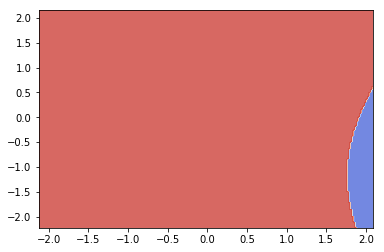

In [0]:
# Plotte Daten und Entscheidungsflächen
plot_contours(plt, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_in2[:, 0], x_in2[:, 1], marker='o', c=y_true2, s=25, edgecolor='k', cmap='spring')